In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Eval - simplifying agent versioning and evaluation

Note: Eval is still in early development, expect breaking changes between versions

## TLDR

`stringdale.eval` is a module that enables you to

* specify expected behavior of complex workflows via yaml `TestCase` files
* evaluate how well workflows adhere to the expected behavior
* detect performance drifts between versions of agentic workflows

## Overview


The need: Current evaluation systems for LLM agents have several shortcomings:
* They are often limited to simple tool calling agents
  * allowing specification of expected outputs and tools
* They require too much boilerplate for adding custom comparison logic
  * Which is crucial in agentic workflows, since each task can have different senses of similarity to expected output

Overview of features:
* A yaml DSL that allows you to define expected behaviors of a partial subset of workflow traces
* Uses port mapping to evaluate sub objects of node output
* Easy to define custom printing logic
* Can define partial order of expected traces, allowing support for parallel events or unknown order of events.
* Automates away boiler plate of detecting differences between different version of an agent
  * Simple agent versioning is already supported by `stringdale` best practices.
* Easy to read pretty prints of eval diffs, improve velocity of tuning agentic workflows


## Concepts

Bellow is a glossary of concepts used in the `eval` framework:

#### Nodes, Test Nodes
Each trace in a stringdale workflows comes from the execution of a node of some diagram/subdiagram
These nodes are identified by the name of the node.

In the context of `eval`, a Test Node specifies a set of conditions that are evaluated for each Node whose name fits
the a name regex of the Test Node.

#### Condition
A test that is run on the output of a node. 
Since workflows are not deterministic, a condition describes how much `distance` there is between the actual and expected output of a node.

#### Test Case
A specification of expected behavior of a single run of a workflow over some input.

* Consists of

  * The diagram input
  * A list of TestNodes
  * Each test nodes has a list of Conditions
* Written by a user in a yaml file.

#### Trace Log
A log file of traces of a diagram. Contains at least:

* Node names - to allow searching node names by patterns
* Outputs - to allow running conditions on them

#### Test Run Result
An evaluation of how well a single agent matched a test case's test nodes when run on the test case's input.
Includes best matching (alignment) between test nodes and nodes.
Includes the `distance` accrued in each condition between the expected output and the actual output of the trace.

#### Test Set
A set of Test Cases, over which an agentic workflow is evaluated over.

#### Comparison
A comparison between both the distance and alignment of two different agent across all test cases in a test set

## Testing a single workflow

### Basic Flow

Let us remember our `ReactAgent` from the decision diagram tutorial.

In [ ]:
from stringdale.core import get_git_root
from stringdale.doc import pprint_yaml
from stringdale.examples.react import ReactAgent

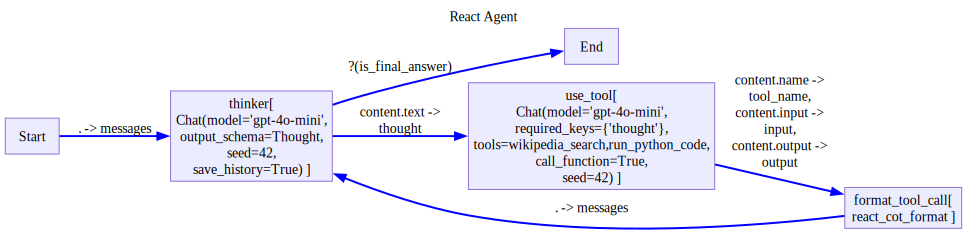

In [ ]:
ReactAgent.draw()

We can specify that we would like it to find the square of obama age using at least two tool calls.

* One that looks up Obama on wikipedia
* The second, that happens later, that computes obama's age

We can express this expectation in the following TestCase:

In [ ]:
obama_test_case = get_git_root()/'sample_data'/'eval'/'obama.yaml'
pprint_yaml(obama_test_case, style='native')

Note that our yaml has 2 top level keys, "inputs" and "test_nodes".
The inputs we will feed into the diagram until it reaches the End or we run out of inputs.
In the case of diagrams without breakpoints, they will finish after a single input is fed.

The "test_nodes" key contains a list of Test Nodes, which in turn contain conditions for us to evaluate by several eval functions.
By default, `eval` uses a "distance" version of cosine similarity, which compares strings.

Now, to run the evaluation, we can use the `eval_single` function.

In [ ]:
from stringdale.eval import eval_single

In [ ]:
# eval single returns both the path to the log file and the dataframe of the test run
test_run,log_path = await eval_single(ReactAgent,obama_test_case)
log_path.relative_to(get_git_root())

Path('sample_data/eval/obama.log.yaml')

In [ ]:
test_run

,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,agg_meta,per_node_comp_id,comp_id
2,anonymous,0,1,eq,content.name,wikipedia_search,wikipedia_search,0.00000,0,use_tool,use_tool,{},None,None,0,2
3,anonymous,0,1,cosine_dist,content.input.q,Barack Obama,Obama,0.32372,0,use_tool,use_tool,{},None,None,1,3
0,anonymous,1,4,eq,content.name,run_python_code,run_python_code,0.00000,1,use_tool,use_tool,{},None,None,0,0
1,anonymous,1,4,eval,content.output,64,({0} < 65) & ({0} > 60),0.00000,1,use_tool,use_tool,{},None,None,1,1


In [ ]:
# TODO from here, fill out None func, solve this at the level of summarize_dataset


at our test run, we can see that a dataframe that contains metadata for each of our comparisons, including:
* node_label - Which node it belongs to
* trace_idx - which trace each node mapped to
* func - The evaluation function used for comparison (e.g. eq, eval, chat_eval)
* key - The path to extract the value to compare from the trace
* actual - The actual value from the trace
* expected - The expected value from the test case
* distance - The computed distance between actual and expected (0 = perfect match)


## Available Eval Functions


The default eval function is used when you don't specify an eval function for a given node.
Are:


Stringdale provides several built-in evaluation functions for comparing outputs with expected values. Each function returns a distance score where:
- 0 indicates a perfect match
- Higher values indicate greater differences
- `np.inf` indicates a mismatch


In [ ]:
from stringdale.eval import EVAL_FUNCS

In [ ]:
{k:v.__name__ for k,v in EVAL_FUNCS.items()}

{'eq': 'eq',
 'eval': 'safe_eval',
 'chat_eval': 'chat_eval',
 'cosine_dist': 'cosine_dist',
 'any': 'eval_any'}

For more information about these functions, see the eval reference section.

## Adding your own Eval functions

An eval function is a function (sync or async) that expects:
* The first positional output to be the result from the agent
* The second positional output to be the expected output from the TestCase
* Any number of kwargs

In [ ]:
import math
import numpy as np

In [ ]:
def word_count(out:str,expected:int,abs=True):
    if not isinstance(out,str):
        return np.inf
    if abs:
        return math.abs(len(out.split()) - expected)
    else:
        return len(out.split()) - expected


To add your own custom eval functions:

In [ ]:
_ = await eval_single(ReactAgent,obama_test_case,
    # pass additional custom eval functions as a dict
    eval_funcs={'word_count':word_count},
    # you can also override which eval function is used by default
    # by passing the `default_eval_func` kwarg the name of the function
    # default_func='word_count'
    )

## Workflow Versioning

The true power of specifying test cases, is to make it easier to check if our workflow improves as we make changes to it,
Including:

* Configure prompts
* Add better context data
* And make sub workflows more adaptive

The main entry point of the eval module, named `eval` takes several versions of an agent and compares their performance on a set of test cases.

In order to use it, we need to be able to generate multiple versions of our agents with ease.
Therefore, in this section we will
1. See how to use stringdale best practices to make our agent's easily configurable
2. See how to call `eval` on a set of agents and test cases.

### Making our agent configurable

We will use the RAG example from the `Hello World` tutorial. However, following the `Keeping Diagrams DRY` tutorial, we made our using a factory pattern.

In [ ]:
from stringdale.examples.rag import RagFactory
from stringdale.db import ChromaClient
from pathlib import Path
import tempfile
import yaml

Using the factory pattern, we can delegate all configuration to configuration files, version them, and invoke our factory to create different versions of our agents with ease.

In [ ]:
def load_agent(conf_dir: Path):
    agent_yaml_path = conf_dir / 'agent.yml'
    vec_db_yaml_path = conf_dir / 'vec_db.yml'

    agent_conf = yaml.safe_load(agent_yaml_path.read_text())
    vec_db_conf = yaml.safe_load(vec_db_yaml_path.read_text())

    db = ChromaClient(persist_path=tempfile.mkdtemp())
    for collection_name, docs in vec_db_conf.items():
        db.add_collection(collection_name, exists_ok=True)
        db.upsert(collection_name, docs)

    agent_conf['db'] = db
    
    Agent = RagFactory(**agent_conf)

    return Agent

In [ ]:
dataset_dir = get_git_root()/'sample_data'/'eval_datasets'
agent_config_dir = dataset_dir/'agent_configs'
! tree {agent_config_dir} --noreport | tail -n +2

├── v001
│   ├── agent.yml
│   └── vec_db.yml
├── v002
│   ├── agent.yml
│   └── vec_db.yml
└── v003
    ├── agent.yml
    └── vec_db.yml


Let us look at these files

In [ ]:
for version in sorted(agent_config_dir.glob('*')):
    print(version.relative_to(agent_config_dir))
    print('vec_db.yml:')
    pprint_yaml(version/'vec_db.yml',style='native')
    print('agent.yml:')
    pprint_yaml(version/'agent.yml',style='native')

    print('-'*100)



v001
vec_db.yml:


agent.yml:


----------------------------------------------------------------------------------------------------
v002
vec_db.yml:


agent.yml:


----------------------------------------------------------------------------------------------------
v003
vec_db.yml:


agent.yml:


----------------------------------------------------------------------------------------------------


As you can see, our agent contains some context about dogs.

In version 2, we changed the prompt to ask for a list in markdown.

In version 3, we added a document about pikachus

Now, we can load all of these agents using our load_agent function.

This is a kind of function that you are expected to build based on the factories and config structure you decide on for your workflow

In [ ]:
versions = sorted([p.name for p in agent_config_dir.glob('*')])
agents = {
    version:load_agent(agent_config_dir/version)
    for version in versions
}
agents

{'v001': <stringdale.base.DiagramSchema RAG Agent @0x114cd2330>,
 'v002': <stringdale.base.DiagramSchema RAG Agent @0x114cd1b80>,
 'v003': <stringdale.base.DiagramSchema RAG Agent @0x114cd2990>}

### Comparing versions

First let us make some testcases

In [ ]:
test_case_dir = dataset_dir/'test_cases'
for file in test_case_dir.glob('*.yaml'):
    print(file.relative_to(test_case_dir))
    pprint_yaml(file,style='native')
    print('-'*100)


pikachus.yaml


----------------------------------------------------------------------------------------------------
goldens.yaml


----------------------------------------------------------------------------------------------------


Now we can finally use `eval` the main entry point of our module

In [ ]:
from stringdale.eval import eval

In [ ]:
out_dir=get_git_root()/'logs'/'eval_results'

eval_res = await eval(
    test_dir=test_case_dir, # where to find the test cases
    out_dir=out_dir, # where to save the results
    agents=agents, # a dict of agents to compare
    base_agent='v001', # the version to compare against, must be a key in the agents dict
)

Summary of runs:                                                                                                   
    v001                                                                                                           
    Dist: 0.78 AvgDist: 0.61 Coverage: 0.04                                                                        
    v002                                                                                                           
    Dist: 0.73 AvgDist: 0.58 Coverage: 0.04                                                                        
    v003                                                                                                           
    Dist: 0.63 AvgDist: 0.46 Coverage: 0.04                                                                        
Summary of comparisons:                                                                                            
    v001 vs v002:                                                                                                  
      improved (#1): goldens(0.11),                                                                                
      regressed (#1): pikachus(-0.00),                                                                             
    v001 vs v003:                                                                                                  
      improved (#1): pikachus(0.30),                                                                               
Datapoints:                                                                                                        
    pikachus - ../../../sample_data/eval_datasets/test_cases/pikachus.yaml                                         
      summary:                                                                                                     
        v001 - Dist: 0.87 AvgDist: 0.87 Coverage: 0.03                                                             
        v002 - Dist: 0.87 AvgDist: 0.87 Coverage: 0.03                                                             
        v003 - Dist: 0.57 AvgDist: 0.57 Coverage: 0.03                                                             
        v001 vs v002: Alignment change: False Score change: regressed Score by: -0.00                              
        v001 vs v003: Alignment change: False Score change: improved Score by: 0.30                                
      logs:                                                                                                        
        v001 - ../../../logs/eval_results/runs/v001/logs/pikachus.log.yaml                                         
        v002 - ../../../logs/eval_results/runs/v002/logs/pikachus.log.yaml                                         
        v003 - ../../../logs/eval_results/runs/v003/logs/pikachus.log.yaml                                         
      details:                                                                                                     
        Comparison #0, node_pattern: chat, key: content, func:                                                     
        expected:                                                                                                  
            They are:                                                                                              
              * dangerous                                                                                          
              * smoke cigarettes                                                                                   
                                                                                                                   
        v001 - matched chat(#1):                                                                                   
            It seems like you're asking about Pikachu, which is a popular character from the                       
            Pokémon franchise, rather than a dog breed. 

By default, the `eval` function will print a summary of the results and comparison between agents, pprinting information about nodes that showed change between versions.
See the reference section for more details about the configuration of eval.

`eval` returns an `EvalResult` object

In [ ]:
eval_res

EvalResult(
  runs: ['v001', 'v002', 'v003'],
  comparisons: [('v001', 'v002'), ('v001', 'v003')]
)

This object can be used to print summary information or infromation about specific datapoints

In [ ]:
eval_res.pprint('pikachus')

pikachus - ../../../sample_data/eval_datasets/test_cases/pikachus.yaml                                             
  summary:                                                                                                         
    v001 - Dist: 0.87 AvgDist: 0.87 Coverage: 0.03                                                                 
    v002 - Dist: 0.87 AvgDist: 0.87 Coverage: 0.03                                                                 
    v003 - Dist: 0.57 AvgDist: 0.57 Coverage: 0.03                                                                 
    v001 vs v002: Alignment change: False Score change: regressed Score by: -0.00                                  
    v001 vs v003: Alignment change: False Score change: improved Score by: 0.30                                    
  logs:                                                                                                            
    v001 - ../../../logs/eval_results/runs/v001/logs/pikachus.log.yaml                                             
    v002 - ../../../logs/eval_results/runs/v002/logs/pikachus.log.yaml                                             
    v003 - ../../../logs/eval_results/runs/v003/logs/pikachus.log.yaml                                             
  details:                                                                                                         
    Comparison #0, node_pattern: chat, key: content, func:                                                         
    expected:                                                                                                      
        They are:                                                                                                  
          * dangerous                                                                                              
          * smoke cigarettes                                                                                       
                                                                                                                   
    v001 - matched chat(#1):                                                                                       
        It seems like you're asking about Pikachu, which is a popular character from the                           
        Pokémon franchise, rather than a dog breed. My expertise is focused on dogs. If                            
        you are interested in information about dogs or any specific dog breeds, feel                              
        free to ask!                                                                                               
                                                                                                                   
    v002 - matched chat(#1), regressed: -0.00:                                                                     
        I'm sorry, but I can't provide information about Pikachus as my expertise is                               
        focused on dogs. If you have any questions about dogs and their relationship                               
        with kids, I'd be happy to help!                                                                           
                                                                                                                   
    v003 - matched chat(#1), improved: 0.30:                                                                       
        Pikachus are described in the document as dangerous creatures that smoke tons of                           
        cigarettes and scare children. However, this description does not relate to                                
        dogs, as it references a fictional character rather than any dog breed. If                                 
        you're looking for information about dogs specifically, I can provide details on                           
        breeds like German Shepherds or Huskies.

Moreover, the `EvalResult` object contains 4 dataframes that information about the runs on both a TestCase level and an Comparison level.
Namely, the dataframe attributes are:

In [ ]:
eval_res.run_summaries.head()

,agent,datapoint,distance,avg_distance,coverage,alignment,serialized_test_case,test_case_path,trace_log_path
0,v001,pikachus,0.870792,0.870792,0.030303,frozendict.frozendict({'0': 1}),"{\n ""inputs"": [\n {\n ""query"": ""tell ...",../../../sample_data/eval_datasets/test_cases/...,../../../logs/eval_results/runs/v001/logs/pika...
1,v001,goldens,0.697439,0.348720,0.055556,"frozendict.frozendict({'0': 0, '1': 1})","{\n ""inputs"": [\n {\n ""query"": ""tell ...",../../../sample_data/eval_datasets/test_cases/...,../../../logs/eval_results/runs/v001/logs/gold...
0,v002,pikachus,0.872816,0.872816,0.030303,frozendict.frozendict({'0': 1}),"{\n ""inputs"": [\n {\n ""query"": ""tell ...",../../../sample_data/eval_datasets/test_cases/...,../../../logs/eval_results/runs/v002/logs/pika...
1,v002,goldens,0.588854,0.294427,0.052632,"frozendict.frozendict({'0': 0, '1': 1})","{\n ""inputs"": [\n {\n ""query"": ""tell ...",../../../sample_data/eval_datasets/test_cases/...,../../../logs/eval_results/runs/v002/logs/gold...
0,v003,pikachus,0.567154,0.567154,0.029412,frozendict.frozendict({'0': 1}),"{\n ""inputs"": [\n {\n ""query"": ""tell ...",../../../sample_data/eval_datasets/test_cases/...,../../../logs/eval_results/runs/v003/logs/pika...


In [ ]:
eval_res.run_details.head()

,agent,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,agg_meta,per_node_comp_id,comp_id
0,v001,pikachus,0,1,cosine_dist,content,"It seems like you're asking about Pikachu, whi...",They are:\n * dangerous\n * smoke cigarettes,0.870792,0,chat,chat,{},NaN,NaN,0,0
1,v001,goldens,0,0,cosine_dist,.[].text,"['The Golden Retriever is a friendly, intellig...","The Golden Retriever is a friendly, intelligen...",0.089650,0,get_docs,get_docs,{},min,{'distances': [np.float64(0.08965025594042875)...,0,0
2,v001,goldens,1,1,cosine_dist,content,"Golden Retrievers are friendly, intelligent do...",They are great with kids.\nAnd their fur is so...,0.607789,1,chat,chat,{},NaN,NaN,0,1
0,v002,pikachus,0,1,cosine_dist,content,"I'm sorry, but I can't provide information abo...",They are:\n * dangerous\n * smoke cigarettes,0.872816,0,chat,chat,{},NaN,NaN,0,0
1,v002,goldens,0,0,cosine_dist,.[].text,"['The Golden Retriever is a friendly, intellig...","The Golden Retriever is a friendly, intelligen...",0.089650,0,get_docs,get_docs,{},min,{'distances': [np.float64(0.08965025594042875)...,0,0


In [ ]:
eval_res.comp_summaries.head()

,from_agent,to_agent,datapoint,alignment_change,score_change_type,total_score_change
0,v001,v002,goldens,False,improved,0.108585
1,v001,v002,pikachus,False,regressed,-0.002024
0,v001,v003,pikachus,False,improved,0.303638


In [ ]:
eval_res.comp_details.head()

,from_agent,to_agent,datapoint,change_type,value,comp_id,node_label,expected,before,after
0,v001,v002,goldens,improved,0.108585,1,1,They are great with kids.\nAnd their fur is so...,"Golden Retrievers are friendly, intelligent do...",Golden Retrievers are friendly and intelligent...
0,v001,v002,pikachus,regressed,-0.002024,0,0,They are:\n * dangerous\n * smoke cigarettes,"It seems like you're asking about Pikachu, whi...","I'm sorry, but I can't provide information abo..."
0,v001,v003,pikachus,improved,0.303638,0,0,They are:\n * dangerous\n * smoke cigarettes,"It seems like you're asking about Pikachu, whi...",Pikachus are described in the document as dang...


All of these data-frames, and more, including trace logs of all runs are saved in the out_dir

In [ ]:
! tree {out_dir} --noreport | tail -n +2

├── comp_details.csv
├── comp_summaries.csv
├── comparisons
│   ├── v001_v002
│   │   ├── details.csv
│   │   └── summary.csv
│   └── v001_v003
│       ├── details.csv
│       └── summary.csv
├── run_details.csv
├── run_summaries.csv
└── runs
    ├── v001
    │   ├── debug.json
    │   ├── details.csv
    │   ├── logs
    │   │   ├── goldens.log.yaml
    │   │   └── pikachus.log.yaml
    │   ├── summary.csv
    │   └── test_cases_loc.txt
    ├── v002
    │   ├── debug.json
    │   ├── details.csv
    │   ├── logs
    │   │   ├── goldens.log.yaml
    │   │   └── pikachus.log.yaml
    │   ├── summary.csv
    │   └── test_cases_loc.txt
    └── v003
        ├── debug.json
        ├── details.csv
        ├── logs
        │   ├── goldens.log.yaml
        │   └── pikachus.log.yaml
        ├── summary.csv
        └── test_cases_loc.txt


`eval` is idempotent by default, running it again using the same outdir will only rerun testCases if the yaml has changed.

## Complex trace dependencies

What do we do if we have some TestNodes we would like to evaluate but we don't know which node will come first?
Luckily, eval can deal with parallel and even partially ordered event expectations!

Lets see this in action below. First, let us make a mixture of experts factory so we have an example of traces happening in parallel.

In [ ]:
import asyncio
from stringdale import Define,V,E, Condition
from stringdale.chat import Chat

In [ ]:
def MOE_Factory(model:str,experts,selector_prompt, synthesizer_prompt):
    """
    model: the model to use for the MOE
    experts: a dictionary of the form {
        expert_name: {
            description: str,
            agent: Agent,
        }}
        The agent will be passes the input through the `input` jinja variable
    expert_selector_prompt: the prompt to use for the expert selector
        can access experts through the experts jinja variable
    synthesizer_prompt: the prompt to use for the synthesizer
        can access experts outputs through the outputs jinja variable
    """

    expert_selector = Chat(model=model,
        messages=[{"role": "system", "content": selector_prompt}],
        choices=list(experts.keys()),
        multi_choice=True,
        experts = experts
    )

    synthesizer = Chat(model=model,
        messages=[{"role": "system", "content": synthesizer_prompt}],
    )

    with Define("Dynamic Expert",type='decision') as DynamicExpert:
        E('Start->state/choice(0=choice)')
        for expert_name in experts:
            V(expert_name,experts[expert_name]['agent'],
                outputs = ['End(output=.)'])
            E(f'Start->{expert_name}(input=input)',
                cond = Condition(expert_name, '0=choice', name=f'{expert_name}_choice')
                )
        E('state/choice->End(choice=.)')

    with Define("Moe") as Schema:
        V('select_experts',expert_selector,
            inputs = ['Start(input=.)'])
        V('experts',DynamicExpert,
            inputs = [
                'select_experts(choice=content)',
                'Start(input=.)'
                ],
            for_each = ['choice'],
            )
        V('synthesize',synthesizer,
            inputs = ['experts(outputs=.)', 'Start(input=.)'],
            outputs = ['End']
            )

    return Schema
            

To control which event returns first for instructive purposes, let us wrap `Chat` with predetermined sleeps

In [ ]:
class SleepyChat(Chat):
    def __init__(self,sleep_time:float=0,**kwargs):
        super().__init__(**kwargs)
        self.sleep_time = sleep_time
    async def __call__(self,*args,**kwargs):
        await asyncio.sleep(self.sleep_time)
        return await super().__call__(*args,**kwargs)


Here is an example configuration for our MOE

In [ ]:
moe_config = get_git_root()/'sample_data'/'eval'/'moe_agent_config.yaml'
pprint_yaml(moe_config,style='native')

Let us create a function that will take a config and return an agent, our use of factories makes this very easy:

In [ ]:
def load_agent(conf_path):
    conf_dict = yaml.safe_load(conf_path.read_text())

    expert_conf = conf_dict.pop('experts')
    experts = {name:{
        'description': expert_conf[name]['description'],
         'agent': SleepyChat(
            **expert_conf[name]['agent']
            )
        }
        for name in expert_conf
    }

    return MOE_Factory(
        experts=experts,
        **conf_dict
    )

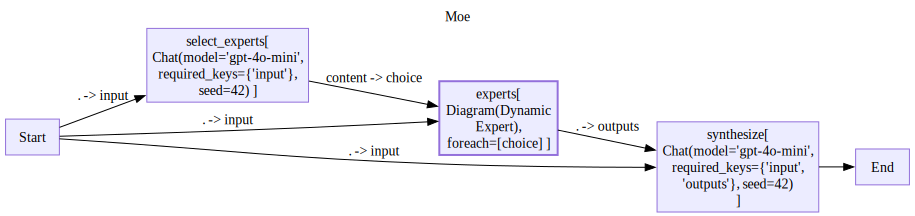

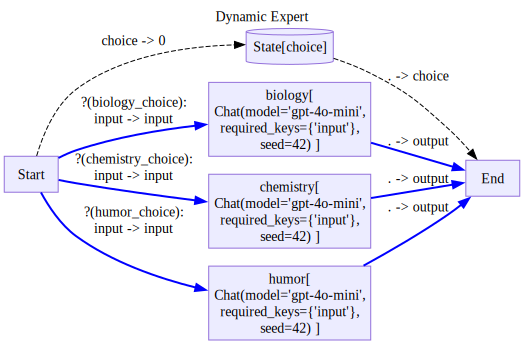

In [ ]:
Moe = load_agent(moe_config)
Moe.draw(recursive=True)

Now let us see some how to express parallelism in TestCases.

First of all, lets see how this fails if parallelism is not specified

In [ ]:
moe_no_par = get_git_root()/'sample_data'/'eval'/'moe_no_par.yaml'
pprint_yaml(moe_no_par,style='native')

Since chemistry is expected first, but during execution comes after biology, we get no alignment

In [ ]:
res,_ = await eval_single(Moe,moe_no_par)
res


No alignment found for test /Users/dean/dl/stringdale/sample_data/eval/moe_no_par.yaml


Now let us use the `parallel` key to express the desire for chemistry to be expected in parallel and not strictly after biology.

In [ ]:
moe_par = get_git_root()/'sample_data'/'eval'/'moe_par.yaml'
pprint_yaml(moe_par,style='native')

In [ ]:
res,_ = await eval_single(Moe,moe_par)
res

,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,agg_meta,per_node_comp_id,comp_id
0,anonymous,0,0,eval,content,"[biology, chemistry, humor]",res = {}\n'biology' in res and 'chemistry' in ...,0.0,0,select_experts,select_experts,{},None,None,0,0
1,anonymous,0,0,eval,content,"[biology, chemistry, humor]",res = {}\n0.5 if 'humor' in res else 0\n,0.5,0,select_experts,select_experts,{},None,None,1,1
2,anonymous,1,3,chat_eval,content,The fun factor in biology or chemistry often d...,experiments,0.0,1,experts[1].chemistry,.*chemistry,{'system_prompt': 'Give a score to the documen...,None,None,0,2
3,anonymous,2,1,chat_eval,content,The fun factor of biology versus chemistry oft...,ecosystems,0.0,2,experts[0].biology,.*biology,{'system_prompt': 'Give a score to the documen...,None,None,0,3


And it works!

We can also specify explicit before and after constraints for more complicated cases using the `before` and `after` keys.
These keys expect references to other nodes through node labels that can be set using the `label` key.


In [ ]:
moe_explicit = get_git_root()/'sample_data'/'eval'/'moe_explicit.yaml'
pprint_yaml(moe_explicit,style='native')


In [ ]:
res,_ = await eval_single(Moe,moe_explicit)
res

,datapoint,node_label,trace_idx,func,key,actual,expected,distance,node_idx,trace_name,node_name,kwargs,aggregation,agg_meta,per_node_comp_id,comp_id
2,anonymous,select,0,eval,content,"[biology, chemistry, humor]",res = {}\n'biology' in res and 'chemistry' in ...,0.0,0,select_experts,select_experts,{},None,None,0,2
3,anonymous,select,0,eval,content,"[biology, chemistry, humor]",res = {}\n0.5 if 'humor' in res else 0\n,0.5,0,select_experts,select_experts,{},None,None,1,3
4,anonymous,1,3,chat_eval,content,The fun factor in biology or chemistry often d...,experiments,0.0,1,experts[1].chemistry,.*chemistry,{'system_prompt': 'Give a score to the documen...,None,None,0,4
0,anonymous,2,1,chat_eval,content,The fun factor of biology versus chemistry oft...,ecosystems,0.0,2,experts[0].biology,.*biology,{'system_prompt': 'Give a score to the documen...,None,None,0,0
1,anonymous,synth,7,any,content,When considering the question of whether biolo...,None,0.0,3,synthesize,synthesize,{},None,None,0,1


## Debugging test cases

In order to debug the structure of our TestCases without running anything, we can use the following endpoint:

In [ ]:
from stringdale.eval import validate_test_case
import rich

In [ ]:
test_case_obj = validate_test_case(moe_explicit)
rich.print(test_case_obj)

TestCase(
    inputs=['What is more fun, biology or chemistry?'],
    test_nodes=[
        TestNode(
            name='select_experts',
            label='select',
            conditions=[
                Condition(
                    key='content',
                    value="res = {}\n'biology' in res and 'chemistry' in res\n",
                    func='eval',
                    kwargs={},
                    aggregation=None
                ),
                Condition(
                    key='content',
                    value="res = {}\n0.5 if 'humor' in res else 0\n",
                    func='eval',
                    kwargs={},
                    aggregation=None
                )
            ],
            before=[],
            after=[],
            parallel=False
        ),
        TestNode(
            name='.*chemistry',
            label='1',
            conditions=[
                Condition(
                    key='content',
                    value='experiments',
                    func='chat_eval',
                    kwargs={
                        'system_prompt': 'Give a score to the document I feed you as follows:\nif it maintains a 
neutral tone, return 0.5\nif it is excited about {{expected}}, return 0\n\nThe document I feed you is:\n{{out}}\n'
                    },
                    aggregation=None
                )
            ],
            before=['synth'],
            after=['select'],
            parallel=False
        ),
        TestNode(
            name='.*biology',
            label='2',
            conditions=[
                Condition(
                    key='content',
                    value='ecosystems',
                    func='chat_eval',
                    kwargs={
                        'system_prompt': 'Give a score to the document I feed you as follows:\nif it maintains a 
neutral tone, return 0.5\nif it is excited about {{expected}}, return 0\n\nThe document I feed you is:\n{{out}}\n'
                    },
                    aggregation=None
                )
            ],
            before=['synth'],
            after=['select'],
            parallel=False
        ),
        TestNode(
            name='synthesize',
            label='synth',
            conditions=[Condition(key='content', value='None', func='any', kwargs={}, aggregation=None)],
            before=[],
            after=[],
            parallel=False
        )
    ]
)

## Advanced Topics

### Avoiding redundant comparisons

In [ ]:
# TODO from here

### Limiting api call rate

In [ ]:
from stringdale.core import semaphore_decorator

In [ ]:
# Example 1: Rate-limiting a function
@semaphore_decorator(2)
async def fetch_data(url: str):
    """
    Fetch data from a URL
    """
    return f"Data fetched from {url}"

# Example 2: Rate-limiting an existing class
Chat = semaphore_decorator(10)(Chat)

### Training and Test sets

In [ ]:
# explain in tutorial

# how do we do training and validation on workflows?

# we have 2 expected datasets, train and test

# we look at the total distance of the validation set to see that we are improving on it

# but we only look at the comparisons and fix our configs or diagrams based on the training set

### Eval behind the scenes